In [48]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, ElasticNetCV
import xgboost as xgb
import numpy as np

# Loading training data

In [ ]:
# we have to separate between features and target features
train_data = pl.read_csv("./data/training_data.csv")
features = train_data.drop("target")
target = train_data.get_column("target")

## Normalizing features

In [ ]:
# in order to handle the different ranges of every feature, we can normalize the data
# which means that every feature will have 0-mean and standard deviation as 1
feature_scaler = StandardScaler()
features_scaled = pl.DataFrame(feature_scaler.fit_transform(features), schema=features.columns)
features_scaled

feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.131936,-0.073789,0.930785,0.479329,1.162466,-0.779245,-1.169156,1.420405,-1.376593,-1.011362,1.131006,0.510386,0.133804,-1.361594,-0.942666,-1.403947,-1.025603,-1.236854,-0.875582,-0.268112
0.182592,0.167003,1.523809,-1.653109,-1.160555,0.079159,0.544694,1.535867,-1.01721,1.46111,-1.707787,1.10354,-1.72701,-1.343029,-0.658247,-1.646802,1.416228,0.112553,-1.606794,-0.566789
-1.029983,1.476856,-0.857746,-0.512359,-1.135292,0.001087,1.538573,-0.961556,0.988358,0.230396,-1.125966,0.586502,0.369323,0.026788,-1.71985,1.253297,0.487305,-1.590263,-0.430466,-1.605898
-0.853103,-0.621776,0.564762,1.177132,0.461478,-0.10561,0.200224,-1.436688,-0.548959,-1.64161,1.208815,1.08119,-1.574711,1.628046,1.199359,0.802291,-0.446532,1.102069,-1.190843,-0.254273
0.497597,-1.675751,-0.540689,0.396905,0.266542,-0.239134,1.544975,-1.565234,-0.391519,-0.444619,-0.391137,-0.622858,-1.253937,1.649769,-0.127784,-0.992809,1.501638,0.368373,0.203401,0.6245
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1.74031,1.476814,1.280988,-1.343003,-0.483624,0.119919,0.134291,0.141171,1.758621,1.029353,-0.826942,0.147834,0.846329,0.993317,-0.14534,-0.800524,0.677224,1.276899,1.388761,-0.585222
0.078306,-1.690825,-1.115392,-0.607038,-0.27902,1.093574,0.320291,-0.196188,-1.188859,1.685307,-1.130002,0.03573,-0.297106,0.18217,-0.696532,0.042276,0.367674,1.319414,1.451897,-0.903073
1.730472,-0.948572,-0.587772,1.133429,-1.465427,-1.447632,0.19344,-0.034781,-0.377364,0.998966,1.480395,0.495826,1.436985,-0.953838,-0.679365,1.671047,0.166653,0.681364,1.125711,1.432179


In [51]:
features_scaled.describe()

statistic,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",800.0,800.0,800.0,800.0,800.0,800.0,800.0,800.0,800.0,800.0,800.0,800.0,800.0,800.0,800.0,800.0,800.0,800.0,800.0,800.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.7764e-17,-1.1546e-16,4.4409e-17,-1.2434e-16,-4.4409e-17,-4.4409e-17,1.5987e-16,3.2863e-16,-7.1054e-17,1.7764e-17,-5.3291e-17,-1.2434e-16,-2.0428e-16,2.0428e-16,3.4639e-16,5.3291e-17,6.2172e-17,-2.4869e-16,8.8818e-18,-2.9310e-16
"""std""",1.000626,1.000626,1.000626,1.000626,1.000626,1.000626,1.000626,1.000626,1.000626,1.000626,1.000626,1.000626,1.000626,1.000626,1.000626,1.000626,1.000626,1.000626,1.000626,1.000626
"""min""",-1.726594,-1.765461,-1.796911,-1.795084,-1.781701,-1.729107,-1.753746,-1.645733,-1.718918,-1.763838,-1.749599,-1.696719,-1.731551,-1.69029,-1.746646,-1.646802,-1.690082,-1.746745,-1.760298,-1.688709
"""25%""",-0.84314,-0.843263,-0.847888,-0.827663,-0.864593,-0.878139,-0.891709,-0.813835,-0.817673,-0.907867,-0.877942,-0.876771,-0.831323,-0.878645,-0.847606,-0.869682,-0.868135,-0.887948,-0.875496,-0.869234
"""50%""",0.03677,0.009987,0.052727,0.074699,0.029815,0.042156,0.002066,-0.097826,-0.058173,0.036691,0.059155,-0.010673,-0.040097,0.00359,-0.020084,-0.006359,-0.06412,0.087585,0.027642,0.021348
"""75%""",0.873199,0.85803,0.891773,0.840075,0.861541,0.859716,0.890157,0.853947,0.858441,0.860171,0.929279,0.828938,0.845127,0.840433,0.880455,0.872076,0.864371,0.851776,0.839798,0.854084
"""max""",1.746271,1.719967,1.68454,1.692154,1.703382,1.714459,1.692557,1.796505,1.803939,1.702357,1.60353,1.756362,1.810272,1.742603,1.74791,1.730053,1.77725,1.670177,1.669067,1.769901


## Modeling

In [ ]:
# setting a seed just for reproducibility
seed = 19972707
# the number of subsets that the training set will be splitted
k_folds = 7

## ElasticNet

In [ ]:
el_net_model = ElasticNetCV(
    # slow steps to explore
    alphas=np.logspace(-3, 1, 100),
    l1_ratio=np.linspace(0.01, 1.0, 50),
    max_iter=10000,
    tol = 1e-04,
    cv=k_folds,
    random_state=seed
)

el_net_model.fit(features_scaled, target)

print(f"The best alpha value is: {el_net_model.alpha_:.6f}")
print(f"The best l1 ratio is: {el_net_model.l1_ratio_:.6f}")

The best alpha value is: 0.095455
The best l1 ratio is: 1.000000


In [54]:
target_pred = el_net_model.predict(features_scaled)

In [55]:
r2 = r2_score(target, target_pred)
mse = mean_squared_error(target, target_pred)
rmse = np.sqrt(mean_squared_error(target, target_pred))
mae = mean_absolute_error(target, target_pred)

In [56]:
scores = pl.DataFrame({"R2":r2, "MSE":mse, "MAE":mae})
scores

R2,MSE,MAE
f64,f64,f64
0.700901,7.737878,2.15457


In [57]:
scores.to_pandas().to_markdown(index=False)

'|       R2 |     MSE |     MAE |\n|---------:|--------:|--------:|\n| 0.700901 | 7.73788 | 2.15457 |'

In [ ]:
# getting the feature coefficients to determine the importance of every feature
feature_coefficients = pl.DataFrame({
    'Feature': features.columns,
    'Coefficient': el_net_model.coef_,
}).sort('Coefficient', descending=True)
feature_coefficients

Feature,Coefficient
str,f64
"""feature_2""",2.670403
"""feature_13""",1.881062
"""feature_9""",1.843988
"""feature_11""",1.534494
"""feature_18""",0.09877
…,…
"""feature_10""",0.0
"""feature_15""",0.0
"""feature_16""",0.0


In [59]:
feature_coefficients.filter(pl.col("Coefficient") != 0).to_pandas().to_markdown(index=False)

'| Feature    |   Coefficient |\n|:-----------|--------------:|\n| feature_2  |    2.6704     |\n| feature_13 |    1.88106    |\n| feature_9  |    1.84399    |\n| feature_11 |    1.53449    |\n| feature_18 |    0.0987695  |\n| feature_12 |    0.0872097  |\n| feature_14 |    0.0473098  |\n| feature_3  |    0.0344598  |\n| feature_19 |   -0.00220183 |\n| feature_17 |   -0.0919922  |'

/var/folders/wj/_wkdntf14_3d9wfq80151hjc0000gp/T/ipykernel_23925/140878318.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


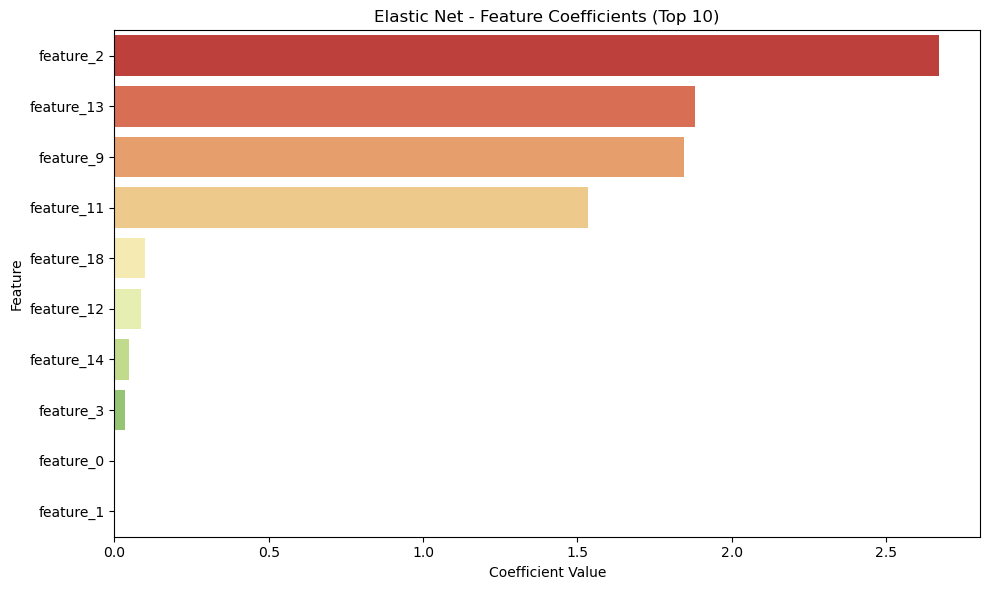

In [ ]:
# visualize the feature importance of elasticnet
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_coefficients.head(10),
    x='Coefficient',
    y='Feature',
    palette='RdYlGn'
)
plt.title('Elastic Net - Feature Coefficients (Top 10)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.savefig("plots/feature_importances/feature_importances_elastic.png", dpi=200)

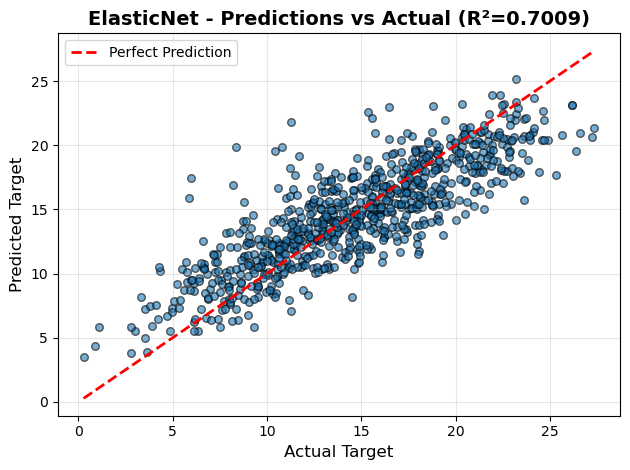

In [ ]:
# plot of the predictions vs actual values with elasticnet
plt.scatter(target, target_pred, alpha=0.6, edgecolors='k', s=30)
plt.plot([target.min(), target.max()], [target.min(), target.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Target', fontsize=12)
plt.ylabel('Predicted Target', fontsize=12)
plt.title(f'ElasticNet - Predictions vs Actual (R²={r2:.4f})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("plots/predictions/elasticnet.png", dpi=200)

## XGBoost

In [ ]:
# we have to define a space to search in order to performs the hyperparameter tunning
params_space = {
    'n_estimators': [300, 400, 500], # number of trees
    'max_depth': [4, 5], # max quantity of levels
    'min_child_weight': [15, 20], # minimum number of datums to consider them as a leaf
    
    'learning_rate': [0.01], # how much faster the model learns
    'subsample': [0.4, 0.5, 0.6], # % of data to use when training
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0], # % of features to use when training
    'colsample_bylevel': [0.7, 0.8, 0.9, 1.0], # % of features to use when getting new level during the training
    'colsample_bynode': [0.7, 0.8, 0.9, 1.0], # % of features to use when splitting a new node
    
    'reg_alpha': [0.01, 0.1, 1, 10], # Lasso regularization
    'reg_lambda': [0.01, 0.1, 1, 10], # Ridge regularization
    'gamma': [2, 5, 7, 10], # Stop growing the tree
}

xgb_model = xgb.XGBRegressor(random_state=seed)

random_search = RandomizedSearchCV(
    xgb_model,
    params_space,
    n_iter=150,
    cv=KFold(n_splits=k_folds, shuffle=True, random_state=seed),
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=seed
)

random_search.fit(features_scaled, target)

Fitting 7 folds for each of 150 candidates, totalling 1050 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBRegressor(...ree=None, ...)"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'colsample_bylevel': [0.7, 0.8, ...], 'colsample_bynode': [0.7, 0.8, ...], 'colsample_bytree': [0.7, 0.8, ...], 'gamma': [2, 5, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",150
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'r2'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used

In [63]:
best_params = random_search.best_params_
best_params

{'subsample': 0.5,
 'reg_lambda': 0.01,
 'reg_alpha': 0.01,
 'n_estimators': 500,
 'min_child_weight': 15,
 'max_depth': 5,
 'learning_rate': 0.01,
 'gamma': 10,
 'colsample_bytree': 0.9,
 'colsample_bynode': 1.0,
 'colsample_bylevel': 0.8}

In [64]:
best_cv_score = random_search.best_score_
best_cv_score

np.float64(0.8324910712152686)

In [ ]:
# training the final model with the best parameters
final_xgb_model = xgb.XGBRegressor(**best_params, random_state=seed, verbosity=1)
final_xgb_model.fit(features_scaled, target)
target_pred = final_xgb_model.predict(features_scaled)

In [66]:
r2 = r2_score(target, target_pred)
mse = mean_squared_error(target, target_pred)
rmse = np.sqrt(mean_squared_error(target, target_pred))
mae = mean_absolute_error(target, target_pred)

In [67]:
scores = pl.DataFrame({"R2":r2, "MSE":mse, "MAE":mae})
scores

R2,MSE,MAE
f64,f64,f64
0.929033,1.835972,1.059891


In [68]:
feature_importance = pl.DataFrame({
    'Feature': features.columns,
    'Importance': final_xgb_model.feature_importances_
}).sort('Importance', descending=True)
feature_importance

Feature,Importance
str,f32
"""feature_2""",0.207422
"""feature_13""",0.139663
"""feature_9""",0.123771
"""feature_11""",0.088593
"""feature_18""",0.058964
…,…
"""feature_16""",0.023497
"""feature_0""",0.023433
"""feature_5""",0.023384


/var/folders/wj/_wkdntf14_3d9wfq80151hjc0000gp/T/ipykernel_23925/3555684668.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


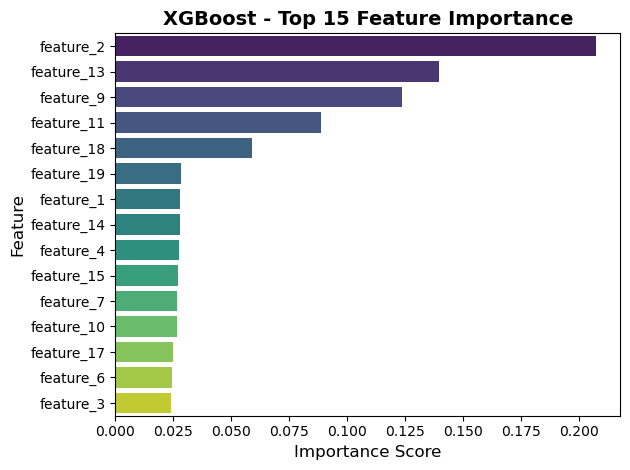

In [ ]:
# plot for feature importance with xgboost
sns.barplot(
    data=feature_importance.head(15),
    x='Importance',
    y='Feature',
    palette='viridis'
)
plt.title('XGBoost - Top 15 Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig("plots/feature_importances/feature_importances_xgboost.png", dpi=200)

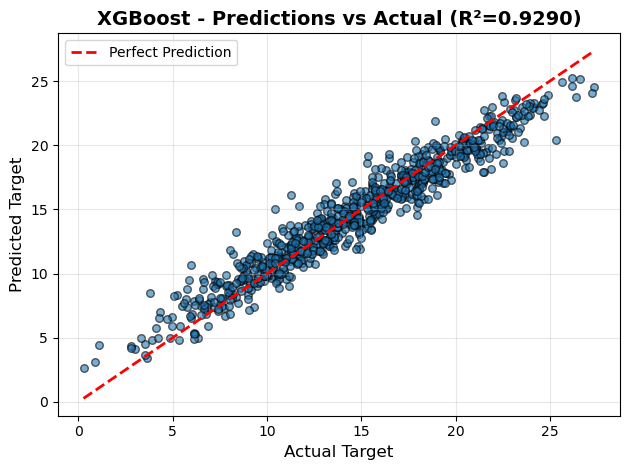

In [ ]:
# plot of predictions vs actual values with xgboost
plt.scatter(target, target_pred, alpha=0.6, edgecolors='k', s=30)
plt.plot([target.min(), target.max()], [target.min(), target.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Target', fontsize=12)
plt.ylabel('Predicted Target', fontsize=12)
plt.title(f'XGBoost - Predictions vs Actual (R²={r2:.4f})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("plots/predictions/xgboost.png", dpi=200)

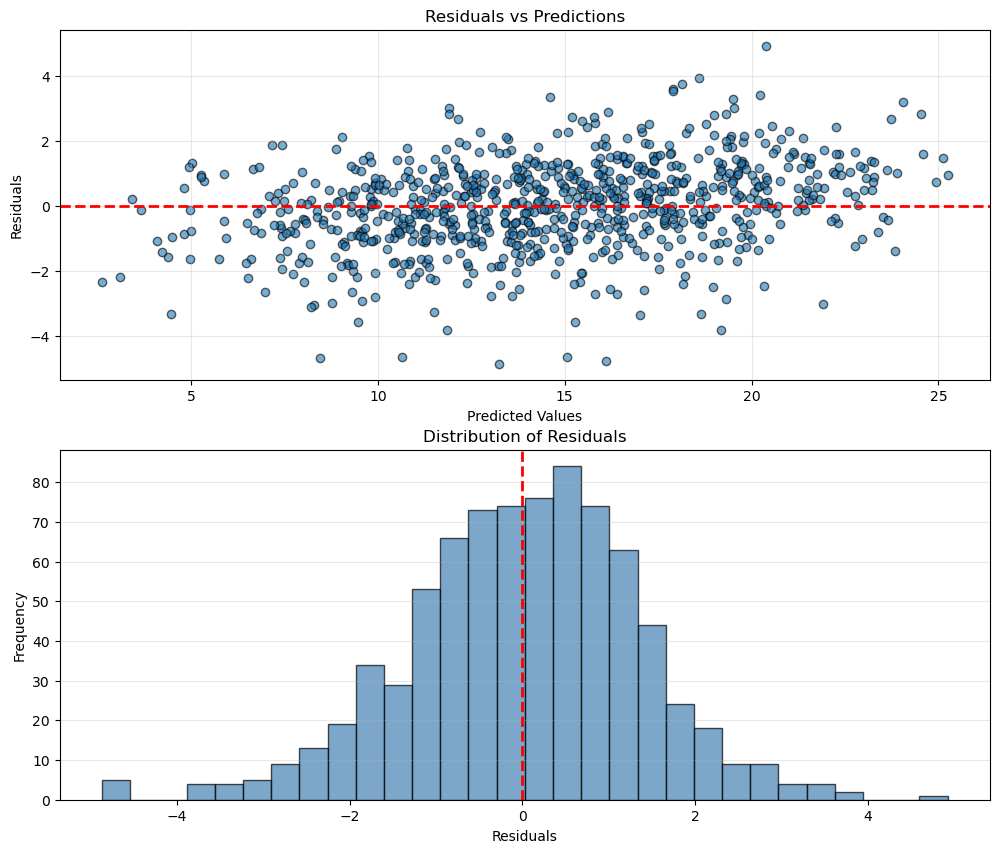

In [ ]:
# plotting the residuals to analyze if the predictions have low or high bias

residuals = target - target_pred

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

axes[0].scatter(target_pred, residuals, alpha=0.6, edgecolors='k')
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Predictions')
axes[0].grid(True, alpha=0.3)

axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Residuals')
axes[1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1].grid(True, alpha=0.3, axis='y')

plt.savefig("plots/residuals/residuals_xgb.png", dpi=200)

# Predictions


In [80]:
blind_test_data = pl.read_csv("data/blind_test_data.csv")

In [95]:
# Normalize the blind test data
blind_test_scaled = pl.DataFrame(feature_scaler.transform(blind_test_data), schema=blind_test_data.columns)
print(f"Mean after scaling: {blind_test_scaled.mean().mean_horizontal().item():.6f}")
print(f"Standard deviation after scaling: {blind_test_scaled.std().mean_horizontal().item():.6f}")

Mean after scaling: 0.010876
Standard deviation after scaling: 1.012400


In [104]:
# Getting predictions
blind_test_predictions = final_xgb_model.predict(blind_test_scaled)
blind_test_predictions = pl.DataFrame(blind_test_predictions, schema=["target_pred"])
blind_test_predictions

target_pred
f32
12.80667
12.566752
15.746464
12.051399
17.287689
…
11.469942
11.052723
10.965826


In [107]:
blind_test_predictions.write_csv("predictions/predictions.csv")